In [41]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [42]:
import numpy as np
import os
import pandas as pd
from keras.utils import Sequence
from PIL import Image
from skimage.transform import resize


class AugmentedImageSequence(Sequence):
    """
    image generator with imgaug support
    """

    def __init__(self, dataset_csv_file, class_names, source_image_dir, batch_size=16,
                 target_size=(224, 224), augmenter=None, verbose=0, steps=None,
                 shuffle_on_epoch_end=True, random_state=1):
        """
        :param dataset_csv_file: str, path of dataset csv file
        :param class_names: list of str
        :param batch_size: int
        :param target_size: tuple(int, int)
        :param augmenter: imgaug object. Do not specify resize in augmenter.
                          It will be done automatically according to input_shape of the model.
        :param verbose: int
        """
        self.dataset_df = pd.read_csv(dataset_csv_file)#r'C:/Users/Vignesh/Downloads/data/Data_Entry_2017.csv')
        self.source_image_dir = source_image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmenter = augmenter
        self.verbose = verbose
        self.shuffle = shuffle_on_epoch_end
        self.random_state = random_state
        self.class_names = class_names
        self.prepare_dataset()
        if steps is None:
            self.steps = int(np.ceil(len(self.x_path) / float(self.batch_size)))
        else:
            self.steps = int(steps)

    def __bool__(self):
        return True

    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        batch_x_path = self.x_path[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.asarray([self.load_image(x_path) for x_path in batch_x_path])
        batch_x = self.transform_batch_images(batch_x)
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

    def load_image(self, image_file):
        image_path = os.path.join(self.source_image_dir, image_file)
        image = Image.open(image_path)
        image_array = np.asarray(image.convert("RGB"))
        image_array = image_array / 255.
        image_array = resize(image_array, self.target_size)
        return image_array

    def transform_batch_images(self, batch_x):
        if self.augmenter is not None:
            batch_x = self.augmenter.augment_images(batch_x)
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        batch_x = (batch_x - imagenet_mean) / imagenet_std
        return batch_x

    def get_y_true(self):
        """
        Use this function to get y_true for predict_generator
        """
        if self.shuffle:
            raise ValueError("""
            You're trying run get_y_true() when generator option 'shuffle_on_epoch_end' is True.
            """)
        return self.y[:self.steps*self.batch_size, :]

    def prepare_dataset(self):
        df = self.dataset_df.sample(frac=1., random_state=self.random_state)
        self.x_path, self.y = df["Image Index"].to_numpy(), df[self.class_names].to_numpy()

    def on_epoch_end(self):
        if self.shuffle:
            self.random_state += 1
            self.prepare_dataset()


In [43]:
import json
import keras.backend as kb
import numpy as np
import os
import shutil
import warnings
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score


class MultipleClassAUROC(Callback):
    """
   tO Monitor mean AUROC and update model
    """
    def __init__(self, sequence, class_names, weights_path, stats=None, workers=1):
        super(Callback, self).__init__()
        self.sequence = sequence
        self.workers = workers
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Calculate the average AUROC and save the best model weights according
        to this metric.
        """
        print("\n*********************************")
        self.stats["lr"] = float(kb.eval(self.model.optimizer.lr))
        print(f"current learning rate: {self.stats['lr']}")

        """
        y_hat shape: (#samples, len(class_names))
        y: [(#samples, 1), (#samples, 1) ... (#samples, 1)]
        """
        y_hat = self.model.predict_generator(self.sequence, workers=self.workers)
        y = self.sequence.get_y_true()

        print(f"*** epoch#{epoch + 1} dev auroc ***")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")
        print("*********************************")

        # customize your multiple class metrics here
        mean_auroc = np.mean(current_auroc)
        print(f"mean auroc: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"update best auroc from {self.stats['best_mean_auroc']} to {mean_auroc}")

            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"update log file: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"update model file: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")
        return

In [44]:
import importlib
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model


class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            )
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, class_names, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(len(class_names), activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [45]:
import numpy as np
import os
import pandas as pd


def get_sample_counts(output_dir, dataset, class_names):
    """
  tO  Get total and class-wise positive sample count of a dataset

    Returns:
    total_count - int
    class_positive_counts - dict of int, ex: {"Effusion": 300, "Infiltration": 500 ...}
    """
    df = pd.read_csv(os.path.join(output_dir, f"{dataset}.csv"))
    total_count = df.shape[0]
    labels = df[class_names].to_numpy()
    positive_counts = np.sum(labels, axis=0)
    class_positive_counts = dict(zip(class_names, positive_counts))
    return total_count, class_positive_counts

In [46]:
import numpy as np


def get_class_weights(total_counts, class_positive_counts, multiply):
    """
    
   tO Calculate class_weight used in training
    Returns:
    class_weight - dict of dict, ex: {"Effusion": { 0: 0.01, 1: 0.99 }, ... }
    """
    def get_single_class_weight(pos_counts, total_counts):
        denominator = (total_counts - pos_counts) * multiply + pos_counts
        return {
            0: pos_counts / denominator,
            1: (denominator - pos_counts) / denominator,
        }

    class_names = list(class_positive_counts.keys())
    label_counts = np.array(list(class_positive_counts.values()))
    class_weights = []
    for i, class_name in enumerate(class_names):
        class_weights.append(get_single_class_weight(label_counts[i], total_counts))

    return class_weights

In [47]:

from imgaug import augmenters as iaa

augmenter = iaa.Sequential(
    [
        iaa.Fliplr(0.5),
    ],
    random_order=True,
)

In [48]:
import json
import shutil
import os
import pickle

from configparser import ConfigParser

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.optimizers import Adam



In [49]:
    # parser config
    config_file = "config.ini"
    cp = ConfigParser()
    cp.read(config_file)

    # default config
    output_dir = cp["DEFAULT"].get("output_dir")
    image_source_dir = cp["DEFAULT"].get("image_source_dir")
    base_model_name = cp["DEFAULT"].get("base_model_name")
    class_names = cp["DEFAULT"].get("class_names").split(",")

    # train config
    use_base_model_weights = cp["TRAIN"].getboolean("use_base_model_weights")
    use_trained_model_weights = cp["TRAIN"].getboolean("use_trained_model_weights")
    use_best_weights = cp["TRAIN"].getboolean("use_best_weights")
    output_weights_name = cp["TRAIN"].get("output_weights_name")
    epochs = cp["TRAIN"].getint("epochs")
    batch_size = cp["TRAIN"].getint("batch_size")
    initial_learning_rate = cp["TRAIN"].getfloat("initial_learning_rate")
    generator_workers = cp["TRAIN"].getint("generator_workers")
    image_dimension = cp["TRAIN"].getint("image_dimension")
    train_steps = cp["TRAIN"].get("train_steps")
    patience_reduce_lr = cp["TRAIN"].getint("patience_reduce_lr")
    min_lr = cp["TRAIN"].getfloat("min_lr")
    validation_steps = cp["TRAIN"].get("validation_steps")
    positive_weights_multiply = cp["TRAIN"].getfloat("positive_weights_multiply")
    dataset_csv_dir = cp["TRAIN"].get("dataset_csv_dir")
    # if previously trained weights is used, never re-split
    if use_trained_model_weights:
        # resuming mode
        print("** use trained model weights **")
        # load training status for resuming
        training_stats_file = os.path.join(output_dir, ".training_stats.json")
        if os.path.isfile(training_stats_file):
            # TODO: add loading previous learning rate?
            training_stats = json.load(open(training_stats_file))
        else:
            training_stats = {}
    else:
        # start over
        training_stats = {}

** use trained model weights **


In [40]:
    show_model_summary = cp["TRAIN"].getboolean("show_model_summary")
    # end parser config

    # check output_dir, create it if not exists
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    running_flag_file = os.path.join(output_dir, ".training.lock")
    if os.path.isfile(running_flag_file):
        raise RuntimeError("A process is running in this directory!!!")
    else:
        open(running_flag_file, "a").close()

    try:
        print(f"backup config file to {output_dir}")
        shutil.copy(config_file, os.path.join(output_dir, os.path.split(config_file)[1]))

        datasets = ["train", "dev", "test"]
        for dataset in datasets:
            shutil.copy(os.path.join(dataset_csv_dir, f"{dataset}.csv"), output_dir)

        # get train/dev sample counts
        train_counts, train_pos_counts = get_sample_counts(output_dir, "train", class_names)
        dev_counts, _ = get_sample_counts(output_dir, "dev", class_names)
        
                # compute steps
        if train_steps == "auto":
            train_steps = int(train_counts / batch_size)
        else:
            try:
                train_steps = int(train_steps)
            except ValueError:
                raise ValueError(f"""
                train_steps: {train_steps} is invalid,
                please use 'auto' or integer.
                """)
        print(f"** train_steps: {train_steps} **")

        if validation_steps == "auto":
            validation_steps = int(dev_counts / batch_size)
        else:
            try:
                validation_steps = int(validation_steps)
            except ValueError:
                raise ValueError(f"""
                validation_steps: {validation_steps} is invalid,
                please use 'auto' or integer.
                """)
        print(f"** validation_steps: {validation_steps} **")

        # compute class weights
        print("** compute class weights **")
        class_weights = get_class_weights(
            train_counts,
            train_pos_counts,
            multiply=positive_weights_multiply,
        )
        print("** class_weights **")
        print(class_weights)

        print("** load model **")
        if use_trained_model_weights:
            if use_best_weights:
                model_weights_file = os.path.join(output_dir, f"best_{output_weights_name}")
            else:
                model_weights_file = os.path.join(output_dir, output_weights_name)
        else:
            model_weights_file = None

        model_factory = ModelFactory()
        model = model_factory.get_model(
            class_names,
            model_name=base_model_name,
            use_base_weights=use_base_model_weights,
            weights_path=model_weights_file,
            input_shape=(image_dimension, image_dimension, 3))

        #if show_model_summary:
            #print(model.summary())

        print("** create image generators **")
        train_sequence = AugmentedImageSequence(
            dataset_csv_file=os.path.join(output_dir, "train.csv"),
            class_names=class_names,
            source_image_dir=image_source_dir,
            batch_size=batch_size,
            target_size=(image_dimension, image_dimension),
            augmenter=augmenter,
            steps=train_steps,
        )
        validation_sequence = AugmentedImageSequence(
            dataset_csv_file=os.path.join(output_dir, "dev.csv"),
            class_names=class_names,
            source_image_dir=image_source_dir,
            batch_size=batch_size,
            target_size=(image_dimension, image_dimension),
            augmenter=augmenter,
            steps=validation_steps,
            shuffle_on_epoch_end=False,
        )

        output_weights_path = os.path.join(output_dir, output_weights_name)
        print(f"** set output weights path to: {output_weights_path} **")

        
        gpus = len(os.getenv("CUDA_VISIBLE_DEVICES", "1").split(","))
        if gpus > 1:
            print(f"** multi_gpu_model is used! gpus={gpus} **")
            model_train = multi_gpu_model(model, gpus)
            # FIXME: currently (Keras 2.1.2) checkpoint doesn't work with multi_gpu_model
            checkpoint = MultiGPUModelCheckpoint(
                filepath=output_weights_path,
                base_model=model,
            )
        else:
            model_train = model
            checkpoint = ModelCheckpoint(
                 output_weights_path,
                 save_weights_only=True,
                 save_best_only=True,
                 verbose=1,
            )

        print("** compile model  **")
        optimizer = Adam(lr=initial_learning_rate)
        model_train.compile(optimizer=optimizer, loss="binary_crossentropy")
        auroc = MultipleClassAUROC(
            sequence=validation_sequence,
            class_names=class_names,
            weights_path=output_weights_path,
            stats=training_stats,
            workers=generator_workers,
        )
        callbacks = [
            checkpoint,
            TensorBoard(log_dir=os.path.join(output_dir, "logs"), batch_size=batch_size),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                              verbose=1, mode="min", min_lr=min_lr),
            auroc,
        ]

        print("** start training **")
        history = model_train.fit_generator(
            generator=train_sequence,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=validation_sequence,
            validation_steps=validation_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            workers=generator_workers,
            shuffle=False,
        )

        # dump history
        print("** dump history **")
        with open(os.path.join(output_dir, "history.pkl"), "wb") as f:
            pickle.dump({
                "history": history.history,
                "auroc": auroc.aurocs,
            }, f)
        print("** done! **")
        
    finally:
        os.remove(running_flag_file)




backup config file to ./experiments/1
** train_steps: 6516 **
** validation_steps: 396 **
** compute class weights from training data **
** class_weights **
[{0: 0.1032743176107264, 1: 0.8967256823892736}, {0: 0.024590950070013235, 1: 0.9754090499299868}, {0: 0.11874436537318013, 1: 0.8812556346268199}, {0: 0.17674026048759903, 1: 0.823259739512401}, {0: 0.05132066061803464, 1: 0.9486793393819654}, {0: 0.05654767613603667, 1: 0.9434523238639633}, {0: 0.012736654326434312, 1: 0.9872633456735657}, {0: 0.04782958970325897, 1: 0.952170410296741}, {0: 0.04120230947768208, 1: 0.9587976905223179}, {0: 0.020505246197226323, 1: 0.9794947538027736}, {0: 0.022826232904302458, 1: 0.9771737670956976}, {0: 0.015076822741833388, 1: 0.9849231772581666}, {0: 0.030201599754474135, 1: 0.9697984002455259}, {0: 0.002004488519747569, 1: 0.9979955114802525}]
** load model **
** create image generators **
** set output weights path to: ./experiments/1\weights.h5 **
** check multiple gpu availability **
** com

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#1 dev auroc ***
1. Atelectasis: 0.7175534165432621
2. Cardiomegaly: 0.6522694417335122
3. Effusion: 0.8383504226258662
4. Infiltration: 0.6755542678120532
5. Mass: 0.6928544794600686
6. Nodule: 0.589131681389139
7. Pneumonia: 0.6935280587008374
8. Pneumothorax: 0.7132891901730635
9. Consolidation: 0.7685370308541352
10. Edema: 0.8455870493358635
11. Emphysema: 0.6960826932619528
12. Fibrosis: 0.6630339015161967
13. Pleural_Thickening: 0.6823364264714198
14. Hernia: 0.7380794178136372
*********************************
mean auroc: 0.7118705341207863
update best auroc from 0 to 0.7118705341207863
update log file: ./experiments/1\best_auroc.log
update model file: ./experiments/1\weights.h5 -> ./experiments/1\best_weights.h5
*********************************
Epoch 2/20
6516/6516 [==============================] - 3485s 534ms/step - loss: 0.1652 - val_loss: 0.1750

Epoch 00002: val_loss improved from 0.17665 to 0.17497, saving model to ./experiments/1\weights.h5

******************

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#2 dev auroc ***
1. Atelectasis: 0.7515976932342643
2. Cardiomegaly: 0.8052251697449521
3. Effusion: 0.8376558810778141
4. Infiltration: 0.6806256763436693
5. Mass: 0.7424345505213716
6. Nodule: 0.6503521167758562
7. Pneumonia: 0.7081810144789734
8. Pneumothorax: 0.7995964885526224
9. Consolidation: 0.7709920065989748
10. Edema: 0.8673980075901329
11. Emphysema: 0.7554454407581613
12. Fibrosis: 0.7224769756264451
13. Pleural_Thickening: 0.7237969624583027
14. Hernia: 0.703875968992248
*********************************
mean auroc: 0.7514038537681278
update best auroc from 0.7118705341207863 to 0.7514038537681278
update log file: ./experiments/1\best_auroc.log
update model file: ./experiments/1\weights.h5 -> ./experiments/1\best_weights.h5
*********************************
Epoch 3/20
6516/6516 [==============================] - 3475s 532ms/step - loss: 0.1606 - val_loss: 0.1661

Epoch 00003: val_loss improved from 0.17497 to 0.16612, saving model to ./experiments/1\weights.h5

*

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#3 dev auroc ***
1. Atelectasis: 0.7624862114297802
2. Cardiomegaly: 0.8295254447813539
3. Effusion: 0.8567317821582311
4. Infiltration: 0.6770742875846683
5. Mass: 0.7699792161575685
6. Nodule: 0.6705195105101376
7. Pneumonia: 0.6961863472404578
8. Pneumothorax: 0.7995737364594299
9. Consolidation: 0.7830452360844962
10. Edema: 0.8696537001897532
11. Emphysema: 0.8190504811892398
12. Fibrosis: 0.6969317389632916
13. Pleural_Thickening: 0.7295409410866738
14. Hernia: 0.719031798766018
*********************************
mean auroc: 0.7628093166143642
update best auroc from 0.7514038537681278 to 0.7628093166143642
update log file: ./experiments/1\best_auroc.log
update model file: ./experiments/1\weights.h5 -> ./experiments/1\best_weights.h5
*********************************
Epoch 4/20
6516/6516 [==============================] - 3477s 532ms/step - loss: 0.1565 - val_loss: 0.1734

Epoch 00004: val_loss did not improve from 0.16612

Epoch 00004: ReduceLROnPlateau reducing learning 

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#4 dev auroc ***
1. Atelectasis: 0.7406839454631016
2. Cardiomegaly: 0.743195328034403
3. Effusion: 0.8557333483906193
4. Infiltration: 0.6856536652816929
5. Mass: 0.7729318488087606
6. Nodule: 0.6314325107895798
7. Pneumonia: 0.7183407747879338
8. Pneumothorax: 0.7994402985074626
9. Consolidation: 0.7799898434146328
10. Edema: 0.8540464895635674
11. Emphysema: 0.7877972924805882
12. Fibrosis: 0.6752418317965356
13. Pleural_Thickening: 0.7521166676089784
14. Hernia: 0.7317513051732321
*********************************
mean auroc: 0.7520253678643635
Epoch 5/20
6516/6516 [==============================] - 3475s 532ms/step - loss: 0.1511 - val_loss: 0.1544

Epoch 00005: val_loss improved from 0.16612 to 0.15439, saving model to ./experiments/1\weights.h5

*********************************
current learning rate: 0.00010000000474974513


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#5 dev auroc ***
1. Atelectasis: 0.7873219628447953
2. Cardiomegaly: 0.8782564675305696
3. Effusion: 0.8712216733798415
4. Infiltration: 0.6929356321224833
5. Mass: 0.8116174576800222
6. Nodule: 0.6905661036420655
7. Pneumonia: 0.7461293983649705
8. Pneumothorax: 0.8423384478399039
9. Consolidation: 0.7873542095118385
10. Edema: 0.8851257115749526
11. Emphysema: 0.8749830517951119
12. Fibrosis: 0.7361159394698554
13. Pleural_Thickening: 0.7686542375756206
14. Hernia: 0.7969414122238042
*********************************
mean auroc: 0.797825836111131
update best auroc from 0.7628093166143642 to 0.797825836111131
update log file: ./experiments/1\best_auroc.log
update model file: ./experiments/1\weights.h5 -> ./experiments/1\best_weights.h5
*********************************
Epoch 6/20
6516/6516 [==============================] - 3488s 534ms/step - loss: 0.1498 - val_loss: 0.1570

Epoch 00006: val_loss did not improve from 0.15439

Epoch 00006: ReduceLROnPlateau reducing learning r

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#6 dev auroc ***
1. Atelectasis: 0.7909293874097132
2. Cardiomegaly: 0.8808774026543361
3. Effusion: 0.8723195870167743
4. Infiltration: 0.6930790837797759
5. Mass: 0.8133028740390745
6. Nodule: 0.6963853937032323
7. Pneumonia: 0.7413286991986696
8. Pneumothorax: 0.8327881029919618
9. Consolidation: 0.796212323136533
10. Edema: 0.8813851992409868
11. Emphysema: 0.8683938692926483
12. Fibrosis: 0.7362042294583225
13. Pleural_Thickening: 0.7625710267428054
14. Hernia: 0.825576121921637
*********************************
mean auroc: 0.7993823786133195
update best auroc from 0.797825836111131 to 0.7993823786133195
update log file: ./experiments/1\best_auroc.log
update model file: ./experiments/1\weights.h5 -> ./experiments/1\best_weights.h5
*********************************
Epoch 7/20
6516/6516 [==============================] - 3533s 542ms/step - loss: 0.1489 - val_loss: 0.1583

Epoch 00007: val_loss did not improve from 0.15439

Epoch 00007: ReduceLROnPlateau reducing learning ra

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#7 dev auroc ***
1. Atelectasis: 0.7911101768822613
2. Cardiomegaly: 0.8845243749054074
3. Effusion: 0.8719605628355326
4. Infiltration: 0.6975771866775327
5. Mass: 0.8160172027415233
6. Nodule: 0.6937020678734436
7. Pneumonia: 0.7483304774601813
8. Pneumothorax: 0.8416878609588838
9. Consolidation: 0.7965585448587197
10. Edema: 0.8826909392789374
11. Emphysema: 0.8625189575281479
12. Fibrosis: 0.7436555366099955
13. Pleural_Thickening: 0.7659686492904393
14. Hernia: 0.8044191319938828
*********************************
mean auroc: 0.800051547849635
update best auroc from 0.7993823786133195 to 0.800051547849635
update log file: ./experiments/1\best_auroc.log
update model file: ./experiments/1\weights.h5 -> ./experiments/1\best_weights.h5
*********************************
Epoch 8/20
6516/6516 [==============================] - 3526s 540ms/step - loss: 0.1485 - val_loss: 0.1605

Epoch 00008: val_loss did not improve from 0.15439

Epoch 00008: ReduceLROnPlateau reducing learning r

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#8 dev auroc ***
1. Atelectasis: 0.793479868147809
2. Cardiomegaly: 0.8822082239537397
3. Effusion: 0.8725867649849278
4. Infiltration: 0.696419720511416
5. Mass: 0.8189455377351966
6. Nodule: 0.6998769677399324
7. Pneumonia: 0.736503723424701
8. Pneumothorax: 0.8378249244876474
9. Consolidation: 0.7944789699763481
10. Edema: 0.8820208728652752
11. Emphysema: 0.8578796922066214
12. Fibrosis: 0.7420111355747955
13. Pleural_Thickening: 0.7629279272912308
14. Hernia: 0.7901597848441702
*********************************
mean auroc: 0.7976660081245581
Epoch 9/20
6516/6516 [==============================] - 3567s 547ms/step - loss: 0.1475 - val_loss: 0.1605

Epoch 00009: val_loss did not improve from 0.15439

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

*********************************
current learning rate: 1.000000082740371e-08


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#9 dev auroc ***
1. Atelectasis: 0.7914445024889584
2. Cardiomegaly: 0.8795100490055372
3. Effusion: 0.8718742904031856
4. Infiltration: 0.69676691026172
5. Mass: 0.81910861239816
6. Nodule: 0.700751923106778
7. Pneumonia: 0.7408027060325346
8. Pneumothorax: 0.8334479136945464
9. Consolidation: 0.7970759134614037
10. Edema: 0.8829257590132827
11. Emphysema: 0.8501121726550325
12. Fibrosis: 0.7382220235697483
13. Pleural_Thickening: 0.7663304086334597
14. Hernia: 0.7982597690238887
*********************************
mean auroc: 0.7976166395534453
Epoch 10/20
6516/6516 [==============================] - 3566s 546ms/step - loss: 0.1484 - val_loss: 0.1617

Epoch 00010: val_loss did not improve from 0.15439

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1e-08.

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#10 dev auroc ***
1. Atelectasis: 0.7913468222067757
2. Cardiomegaly: 0.8844106027315759
3. Effusion: 0.871574760272902
4. Infiltration: 0.696915705868993
5. Mass: 0.8196389554997748
6. Nodule: 0.7011034091967584
7. Pneumonia: 0.7393805014333314
8. Pneumothorax: 0.8333839618650322
9. Consolidation: 0.7965215097960545
10. Edema: 0.8830846774193548
11. Emphysema: 0.8547961672595626
12. Fibrosis: 0.7287253316852536
13. Pleural_Thickening: 0.7654924874201391
14. Hernia: 0.8164425460106524
*********************************
mean auroc: 0.7987726741904401
Epoch 11/20
6516/6516 [==============================] - 3506s 537ms/step - loss: 0.1478 - val_loss: 0.1582

Epoch 00011: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#11 dev auroc ***
1. Atelectasis: 0.7916563229903767
2. Cardiomegaly: 0.8786457979969835
3. Effusion: 0.8724527519088381
4. Infiltration: 0.6989881564708553
5. Mass: 0.8206870256116001
6. Nodule: 0.7023087469338964
7. Pneumonia: 0.7482090944218424
8. Pneumothorax: 0.8412291295664067
9. Consolidation: 0.7952718569997672
10. Edema: 0.8821287950664137
11. Emphysema: 0.8580082888952566
12. Fibrosis: 0.7435102260039768
13. Pleural_Thickening: 0.7651709235596765
14. Hernia: 0.7940199335548174
*********************************
mean auroc: 0.799449074998622
Epoch 12/20
6516/6516 [==============================] - 3897s 597ms/step - loss: 0.1483 - val_loss: 0.1597

Epoch 00012: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#12 dev auroc ***
1. Atelectasis: 0.7922812609283187
2. Cardiomegaly: 0.8758954339782163
3. Effusion: 0.8722659090848506
4. Infiltration: 0.6985586364911626
5. Mass: 0.8225266386433683
6. Nodule: 0.7035024412394821
7. Pneumonia: 0.7413286991986696
8. Pneumothorax: 0.8403227353673295
9. Consolidation: 0.79457324104495
10. Edema: 0.8843868595825427
11. Emphysema: 0.8598645541399048
12. Fibrosis: 0.7373446418093561
13. Pleural_Thickening: 0.7666294453553457
14. Hernia: 0.8013394505088857
*********************************
mean auroc: 0.7993442819551702
Epoch 13/20
6516/6516 [==============================] - 3914s 599ms/step - loss: 0.1492 - val_loss: 0.1613

Epoch 00013: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#13 dev auroc ***
1. Atelectasis: 0.7915931815925016
2. Cardiomegaly: 0.8852028328227503
3. Effusion: 0.8718190372723565
4. Infiltration: 0.6967353475571468
5. Mass: 0.8199721137653706
6. Nodule: 0.7037884330269818
7. Pneumonia: 0.745864378731264
8. Pneumothorax: 0.8401296500359113
9. Consolidation: 0.7940564335795791
10. Edema: 0.884181688804554
11. Emphysema: 0.857045211520586
12. Fibrosis: 0.7341422903526634
13. Pleural_Thickening: 0.7632927785944479
14. Hernia: 0.8268206507409166
*********************************
mean auroc: 0.8010460020283592
update best auroc from 0.800051547849635 to 0.8010460020283592
update log file: ./experiments/1\best_auroc.log
update model file: ./experiments/1\weights.h5 -> ./experiments/1\best_weights.h5
*********************************
Epoch 14/20
6516/6516 [==============================] - 3553s 544ms/step - loss: 0.1486 - val_loss: 0.1596

Epoch 00014: val_loss did not improve from 0.15439

*********************************
current learning

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#14 dev auroc ***
1. Atelectasis: 0.7921932947073478
2. Cardiomegaly: 0.8785643830469025
3. Effusion: 0.872876601583487
4. Infiltration: 0.6967124687712923
5. Mass: 0.8196450299141546
6. Nodule: 0.7020111117148445
7. Pneumonia: 0.7462123434411687
8. Pneumothorax: 0.8437656804966597
9. Consolidation: 0.7963728084080816
10. Edema: 0.879784155597723
11. Emphysema: 0.8597792889441791
12. Fibrosis: 0.7408210601052491
13. Pleural_Thickening: 0.7662972804884944
14. Hernia: 0.818045667879555
*********************************
mean auroc: 0.8009343696499386
Epoch 15/20
6516/6516 [==============================] - 3513s 538ms/step - loss: 0.1481 - val_loss: 0.1601

Epoch 00015: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#15 dev auroc ***
1. Atelectasis: 0.7919458559814871
2. Cardiomegaly: 0.8825537156008788
3. Effusion: 0.8717974691642697
4. Infiltration: 0.6977233938090339
5. Mass: 0.8216631372761578
6. Nodule: 0.7050631462104512
7. Pneumonia: 0.7467221522021917
8. Pneumothorax: 0.8399740749121893
9. Consolidation: 0.7975169673895051
10. Edema: 0.8823564990512335
11. Emphysema: 0.8580795761900436
12. Fibrosis: 0.7368884768689428
13. Pleural_Thickening: 0.769327401481314
14. Hernia: 0.7951062595580869
*********************************
mean auroc: 0.7997655804068419
Epoch 16/20
6516/6516 [==============================] - 3525s 540ms/step - loss: 0.1475 - val_loss: 0.1639

Epoch 00016: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#16 dev auroc ***
1. Atelectasis: 0.7911984129382661
2. Cardiomegaly: 0.8783765023928688
3. Effusion: 0.8725353892667885
4. Infiltration: 0.6955865653097487
5. Mass: 0.8158849674131032
6. Nodule: 0.6998696905952121
7. Pneumonia: 0.7365745301970654
8. Pneumothorax: 0.8298696858489361
9. Consolidation: 0.7947746893403551
10. Edema: 0.881399430740038
11. Emphysema: 0.8521193992298176
12. Fibrosis: 0.7347253721514982
13. Pleural_Thickening: 0.7578032241194098
14. Hernia: 0.7832726889205295
*********************************
mean auroc: 0.7945707534616885
Epoch 17/20
6516/6516 [==============================] - 3493s 535ms/step - loss: 0.1480 - val_loss: 0.1593

Epoch 00017: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#17 dev auroc ***
1. Atelectasis: 0.7913951226777997
2. Cardiomegaly: 0.8770519437819332
3. Effusion: 0.8721260798897266
4. Infiltration: 0.6973021402519672
5. Mass: 0.8190539426687424
6. Nodule: 0.6984991616729282
7. Pneumonia: 0.7471995921529911
8. Pneumothorax: 0.8416804819016322
9. Consolidation: 0.7979720497504343
10. Edema: 0.8803830645161289
11. Emphysema: 0.8563840568061895
12. Fibrosis: 0.7407640394876974
13. Pleural_Thickening: 0.7659023930005088
14. Hernia: 0.7964140695037705
*********************************
mean auroc: 0.7987234384330322
Epoch 18/20
6516/6516 [==============================] - 3495s 535ms/step - loss: 0.1481 - val_loss: 0.1591

Epoch 00018: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#18 dev auroc ***
1. Atelectasis: 0.7923900044468813
2. Cardiomegaly: 0.8821727353857554
3. Effusion: 0.8717210114327936
4. Infiltration: 0.6968632683598082
5. Mass: 0.8180180213856767
6. Nodule: 0.7026041990095321
7. Pneumonia: 0.7442742609290254
8. Pneumothorax: 0.8421521266443
9. Consolidation: 0.7965877239990014
10. Edema: 0.8833040796963946
11. Emphysema: 0.8606291453212471
12. Fibrosis: 0.7368829587446636
13. Pleural_Thickening: 0.7683494586419403
14. Hernia: 0.7918050941306755
*********************************
mean auroc: 0.7991252920091211
Epoch 19/20
6516/6516 [==============================] - 3499s 536ms/step - loss: 0.1481 - val_loss: 0.1668

Epoch 00019: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#19 dev auroc ***
1. Atelectasis: 0.790125818679492
2. Cardiomegaly: 0.8714979828924228
3. Effusion: 0.8711007465715794
4. Infiltration: 0.6982293155736063
5. Mass: 0.8214042737710524
6. Nodule: 0.7016724819138696
7. Pneumonia: 0.7448498188358152
8. Pneumothorax: 0.8360539507472525
9. Consolidation: 0.7968329410048286
10. Edema: 0.8820173149905123
11. Emphysema: 0.8565517916174529
12. Fibrosis: 0.734350139700513
13. Pleural_Thickening: 0.7630604398710918
14. Hernia: 0.7800137109107209
*********************************
mean auroc: 0.7962686233628721
Epoch 20/20
6516/6516 [==============================] - 3490s 535ms/step - loss: 0.1476 - val_loss: 0.1621

Epoch 00020: val_loss did not improve from 0.15439

*********************************
current learning rate: 9.99999993922529e-09


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#20 dev auroc ***
1. Atelectasis: 0.7919110472621459
2. Cardiomegaly: 0.8821602100088201
3. Effusion: 0.8719125798534968
4. Infiltration: 0.6974642957341919
5. Mass: 0.818169180851203
6. Nodule: 0.6990398535256311
7. Pneumonia: 0.7472703989253554
8. Pneumothorax: 0.8381096331132735
9. Consolidation: 0.7964025486856762
10. Edema: 0.8839373814041745
11. Emphysema: 0.8559745043086879
12. Fibrosis: 0.7376242267728353
13. Pleural_Thickening: 0.7585249759710523
14. Hernia: 0.8161050466698307
*********************************
mean auroc: 0.799614705934741
** dump history **
** done! **


In [59]:
# test config
batch_size = cp["TEST"].getint("batch_size")
test_steps = cp["TEST"].get("test_steps")
use_best_weights = cp["TEST"].getboolean("use_best_weights")

# default config
output_dir = cp["DEFAULT"].get("output_dir")
base_model_name = cp["DEFAULT"].get("base_model_name")
class_names = cp["DEFAULT"].get("class_names").split(",")
image_source_dir = cp["DEFAULT"].get("image_source_dir")

# parse weights file path
#output_weights_name = cp["TRAIN"].get("output_weights_name")
output_weights_name = "best_weights1.h5"
weights_path = os.path.join(output_dir, output_weights_name)
best_weights_path = os.path.join(output_dir, f"best_{output_weights_name}")

In [50]:
# get test sample count
test_counts, _ = get_sample_counts(output_dir, "test", class_names)

# compute steps
if test_steps == "auto":
    test_steps = int(test_counts / batch_size)
else:
    try:
        test_steps = int(test_steps)
    except ValueError:
        raise ValueError(f"""
            test_steps: {test_steps} is invalid,
            please use 'auto' or integer.S
            """)
print(f"** test_steps: {test_steps} **")

** test_steps: 47 **


In [51]:
print("** load test generator **")
test_sequence = AugmentedImageSequence(
    dataset_csv_file=os.path.join(output_dir, "dev.csv"),
    class_names=class_names,
    source_image_dir=image_source_dir,
    batch_size=batch_size,
    target_size=(image_dimension, image_dimension),
    augmenter=None,
    steps=test_steps,
    shuffle_on_epoch_end=False,
)

** load test generator **


In [52]:
print("** load model **")
if use_best_weights:
    print("** use best weights **")
    model_weights_path = best_weights_path
else:
    print("** use last weights **")
    model_weights_path = weights_path
model_factory = ModelFactory()
model = model_factory.get_model(
    class_names,
    model_name=base_model_name,
    use_base_weights=False,
    weights_path=model_weights_path)

** load model **
** use best weights **
load model weights_path: ./experiments/6\best_best_weights1.h5


In [63]:
print("** make prediction **")
y_hat = model.predict_generator(test_sequence, verbose=1)
y = test_sequence.get_y_true()

test_log_path = os.path.join(output_dir, "test.log")
print(f"** write log to {test_log_path} **")
aurocs = []
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            score = roc_auc_score(y[:, i], y_hat[:, i])
            aurocs.append(score)
        except ValueError:
            score = 0
        print(f"{class_names[i]}: {score}")
        f.write(f"{class_names[i]}: {score}\n")
    mean_auroc = np.mean(aurocs)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")

** make prediction **


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


47/47 [==============================] - 167s 4s/step
** write log to ./experiments/1\test.log **
Atelectasis: 0.8210690294811533
Cardiomegaly: 0.8725239071038251
Effusion: 0.8890475772875142
Infiltration: 0.7220461708094217
Mass: 0.8406888546980862
Nodule: 0.744987170515512
Pneumonia: 0.7550844922984896
Pneumothorax: 0.8980582524271845
Consolidation: 0.7468601171660977
Edema: 0.8643826322930801
Emphysema: 0.9230561189993238
Fibrosis: 0.7642034378876484
Pleural_Thickening: 0.7849668722869545
Hernia: 0.7684893596717244
mean auroc: 0.8139617137804296


** write log to ./experiments/1\test.log **
Atelectasis: 0.8210690294811533
Cardiomegaly: 0.8725239071038251
Effusion: 0.8890475772875142
Infiltration: 0.7220461708094217
Mass: 0.8406888546980862
Nodule: 0.744987170515512
Pneumonia: 0.7550844922984896
Pneumothorax: 0.8980582524271845
Consolidation: 0.7468601171660977
Edema: 0.8643826322930801
Emphysema: 0.9230561189993238
Fibrosis: 0.7642034378876484
Pleural_Thickening: 0.7849668722869545
Hernia: 0.7684893596717244
mean auroc: 0.8139617137804296


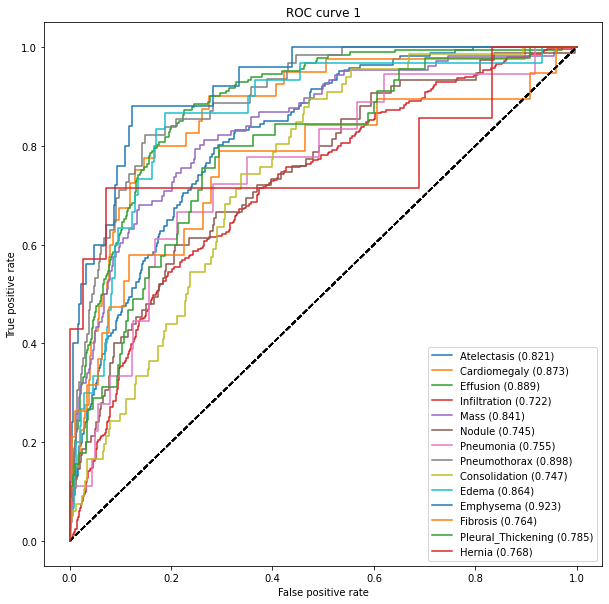

In [64]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score
print(f"** write log to {test_log_path} **")
aurocs = []
when = '1'
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            gt = y[:,i]
            pred = y_hat[:,i]
            score = roc_auc_score(gt, pred)
            aurocs.append(score)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                 label=class_names[i] + " (" + str(round(score, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        
            #plt.show()
        except ValueError:
            score = 0
            
        print(f"{class_names[i]}: {score}")
        f.write(f"{class_names[i]}: {score}\n")
    mean_auroc = np.mean(aurocs)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")
    

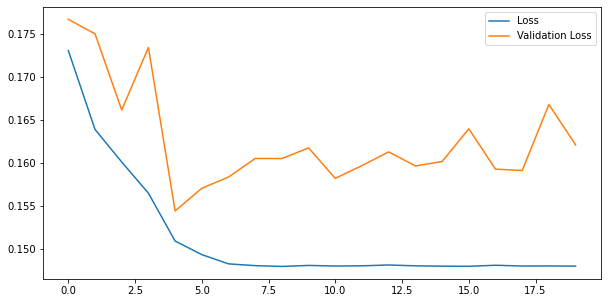

In [130]:

fig, (ax1) = plt.subplots(1,figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()



### RE-TRAINING THE MODEL

In [10]:
METRICS = ['BinaryAccuracy', 'Precision' , 'Recall']   

In [11]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [14]:
show_model_summary = cp["TRAIN"].getboolean("show_model_summary")
# end parser config

# check output_dir, create it if not exists
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

running_flag_file = os.path.join(output_dir, ".training.lock")
if os.path.isfile(running_flag_file):
    raise RuntimeError("A process is running in this directory!!!")
else:
    open(running_flag_file, "a").close()

try:
    print(f"backup config file to {output_dir}")
    shutil.copy(config_file, os.path.join(output_dir, os.path.split(config_file)[1]))

    datasets = ["train", "dev", "test"]
    for dataset in datasets:
        shutil.copy(os.path.join(dataset_csv_dir, f"{dataset}.csv"), output_dir)

    # get train sample counts
    train_counts, train_pos_counts = get_sample_counts(output_dir, "train", class_names)
    dev_counts, _ = get_sample_counts(output_dir, "dev", class_names)

            # compute steps
    if train_steps == "auto":
        train_steps = int(train_counts / batch_size)
    else:
        try:
            train_steps = int(train_steps)
        except ValueError:
            raise ValueError(f"""
            train_steps: {train_steps} is invalid,
            please use 'auto' or integer.
            """)
    print(f"** train_steps: {train_steps} **")

    if validation_steps == "auto":
        validation_steps = int(dev_counts / batch_size)
    else:
        try:
            validation_steps = int(validation_steps)
        except ValueError:
            raise ValueError(f"""
            validation_steps: {validation_steps} is invalid,
            please use 'auto' or integer.
            """)
    print(f"** validation_steps: {validation_steps} **")

    # compute class weights
    print("** compute class weights **")
    class_weights = get_class_weights(
        train_counts,
        train_pos_counts,
        multiply=positive_weights_multiply,
    )
    #print("** class_weights **")
    #print(class_weights)

    print("** load model **")
    if use_trained_model_weights:
        if use_best_weights:
            model_weights_file = os.path.join(output_dir, f"best_{output_weights_name}")
        else:
            model_weights_file = os.path.join(output_dir, output_weights_name)
    else:
        model_weights_file = None

    model_factory = ModelFactory()
    model = model_factory.get_model(
        class_names,
        model_name=base_model_name,
        use_base_weights=use_base_model_weights,
        weights_path=model_weights_file,
        input_shape=(image_dimension, image_dimension, 3))

    #if show_model_summary:
        #print(model.summary())

    
    train_sequence = AugmentedImageSequence(
        dataset_csv_file=os.path.join(output_dir, "train.csv"),
        class_names=class_names,
        source_image_dir=image_source_dir,
        batch_size=batch_size,
        target_size=(image_dimension, image_dimension),
        augmenter=augmenter,
        steps=train_steps,
    )
    validation_sequence = AugmentedImageSequence(
        dataset_csv_file=os.path.join(output_dir, "dev.csv"),
        class_names=class_names,
        source_image_dir=image_source_dir,
        batch_size=batch_size,
        target_size=(image_dimension, image_dimension),
        augmenter=augmenter,
        steps=validation_steps,
        shuffle_on_epoch_end=False,
    )

    output_weights_path = os.path.join(output_dir, output_weights_name)
    print(f"** set output weights path to: {output_weights_path} **")

    print("** check multiple gpu availability **")
    gpus = len(os.getenv("CUDA_VISIBLE_DEVICES", "1").split(","))
    if gpus > 1:
        print(f"** multi_gpu_model is used! gpus={gpus} **")
        model_train = multi_gpu_model(model, gpus)
        # FIXME: currently (Keras 2.1.2) checkpoint doesn't work with multi_gpu_model
        checkpoint = MultiGPUModelCheckpoint(
            filepath=output_weights_path,
            base_model=model,
        )
    else:
        model_train = model
        checkpoint = ModelCheckpoint(
             output_weights_path,
             save_weights_only=True,
             save_best_only=True,
             verbose=1,
        )

    print("** compile model **")
    optimizer = Adam(lr=initial_learning_rate)
    model_train.compile(optimizer=optimizer, loss="binary_crossentropy")
    auroc = MultipleClassAUROC(
        sequence=validation_sequence,
        class_names=class_names,
        weights_path=output_weights_path,
        stats=training_stats,
        workers=generator_workers,
    )
    callbacks = [
        checkpoint,
        TensorBoard(log_dir=os.path.join(output_dir, "logs"), batch_size=batch_size),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                          verbose=1, mode="min", min_lr=min_lr),
        auroc,
    ]
finally:
        os.remove(running_flag_file)

backup config file to ./experiments/6
** train_steps: 6516 **
** validation_steps: 396 **
** compute class weights from training data **
** class_weights **
[{0: 0.1032743176107264, 1: 0.8967256823892736}, {0: 0.024590950070013235, 1: 0.9754090499299868}, {0: 0.11874436537318013, 1: 0.8812556346268199}, {0: 0.17674026048759903, 1: 0.823259739512401}, {0: 0.05132066061803464, 1: 0.9486793393819654}, {0: 0.05654767613603667, 1: 0.9434523238639633}, {0: 0.012736654326434312, 1: 0.9872633456735657}, {0: 0.04782958970325897, 1: 0.952170410296741}, {0: 0.04120230947768208, 1: 0.9587976905223179}, {0: 0.020505246197226323, 1: 0.9794947538027736}, {0: 0.022826232904302458, 1: 0.9771737670956976}, {0: 0.015076822741833388, 1: 0.9849231772581666}, {0: 0.030201599754474135, 1: 0.9697984002455259}, {0: 0.002004488519747569, 1: 0.9979955114802525}]
** load model **
load model weights_path: ./experiments/6\best_weights.h5
** create image generators **
** set output weights path to: ./experiments/6\w

In [40]:
model_train.load_weights('best_best_weights1.h5')

In [15]:

    
    model_train.compile(optimizer=optimizer, loss="binary_crossentropy" , metrics = METRICS)
    callbacks = [
            checkpoint,
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                              verbose=1, mode="min", min_lr=min_lr),
            auroc,
        ]
    history = model_train.fit_generator(
            generator=train_sequence,
            steps_per_epoch=1000,
            epochs=8,
            validation_data=validation_sequence,
            validation_steps=200,
            callbacks=callbacks,
            class_weight=class_weights,
            workers=generator_workers,
            shuffle=False,
        )

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
1000/1000 [==============================] - 826s 792ms/step - loss: 0.1370 - binary_accuracy: 0.9520 - precision: 0.5954 - recall: 0.1455 - val_loss: 0.1602 - val_binary_accuracy: 0.9452 - val_precision: 0.4573 - val_recall: 0.1779

Epoch 00001: val_loss improved from inf to 0.16016, saving model to ./experiments/6\weights.h5

*********************************
current learning rate: 0.0010000000474974513


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#1 dev auroc ***
1. Atelectasis: 0.8025417380830057
2. Cardiomegaly: 0.8727327763019869
3. Effusion: 0.8699324336604981
4. Infiltration: 0.7184681901377403
5. Mass: 0.8346661221499315
6. Nodule: 0.7290311500605459
7. Pneumonia: 0.725490235746091
8. Pneumothorax: 0.8451929131534155
9. Consolidation: 0.7822848950252371
10. Edema: 0.8920327324478179
11. Emphysema: 0.8822291956416906
12. Fibrosis: 0.7572154073387374
13. Pleural_Thickening: 0.774391148866399
14. Hernia: 0.8711807203501556
*********************************
mean auroc: 0.8112421184973752
update best auroc from 0 to 0.8112421184973752
update log file: ./experiments/6\best_auroc.log
update model file: ./experiments/6\weights.h5 -> ./experiments/6\best_weights.h5
*********************************
Epoch 2/8
1000/1000 [==============================] - 607s 603ms/step - loss: 0.1400 - binary_accuracy: 0.9508 - precision: 0.6040 - recall: 0.1501 - val_loss: 0.1580 - val_binary_accuracy: 0.9475 - val_precision: 0.5169 - val

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#2 dev auroc ***
1. Atelectasis: 0.7925276203140449
2. Cardiomegaly: 0.8762116997458393
3. Effusion: 0.875182450442425
4. Infiltration: 0.7127269508757398
5. Mass: 0.8191660857034452
6. Nodule: 0.7445144883099947
7. Pneumonia: 0.7652593652071706
8. Pneumothorax: 0.8502377286277906
9. Consolidation: 0.7739026258420567
10. Edema: 0.8673209203036053
11. Emphysema: 0.866498465925372
12. Fibrosis: 0.745976827556777
13. Pleural_Thickening: 0.7663679538644202
14. Hernia: 0.8440120234140167
*********************************
mean auroc: 0.8071360861523357
Epoch 3/8
1000/1000 [==============================] - 592s 588ms/step - loss: 0.1430 - binary_accuracy: 0.9505 - precision: 0.5971 - recall: 0.1420 - val_loss: 0.1666 - val_binary_accuracy: 0.9442 - val_precision: 0.4394 - val_recall: 0.1859

Epoch 00003: val_loss did not improve from 0.15796

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

*********************************
current learning rate: 0.0

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#3 dev auroc ***
1. Atelectasis: 0.7959734136938041
2. Cardiomegaly: 0.8744790226030866
3. Effusion: 0.8674499201858833
4. Infiltration: 0.7110632289481771
5. Mass: 0.8302042311566993
6. Nodule: 0.7043538671717329
7. Pneumonia: 0.7339304030119178
8. Pneumothorax: 0.8421502818799872
9. Consolidation: 0.7660402503794692
10. Edema: 0.878472485768501
11. Emphysema: 0.8869593173193182
12. Fibrosis: 0.6943694899229855
13. Pleural_Thickening: 0.739219659919715
14. Hernia: 0.9049939355587195
*********************************
mean auroc: 0.8021185362514284
Epoch 4/8
1000/1000 [==============================] - 611s 607ms/step - loss: 0.1362 - binary_accuracy: 0.9523 - precision: 0.6360 - recall: 0.1467 - val_loss: 0.1505 - val_binary_accuracy: 0.9483 - val_precision: 0.5504 - val_recall: 0.1447

Epoch 00004: val_loss improved from 0.15796 to 0.15052, saving model to ./experiments/6\weights.h5

*********************************
current learning rate: 0.00010000000474974513


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#4 dev auroc ***
1. Atelectasis: 0.8130304956761635
2. Cardiomegaly: 0.8900919049532647
3. Effusion: 0.8763032650480568
4. Infiltration: 0.7199341024168013
5. Mass: 0.850355867230123
6. Nodule: 0.7454090919675846
7. Pneumonia: 0.762827658339116
8. Pneumothorax: 0.8737197335668395
9. Consolidation: 0.7908467281486117
10. Edema: 0.8806629506641367
11. Emphysema: 0.8962043010001187
12. Fibrosis: 0.7570645786084395
13. Pleural_Thickening: 0.7879966571493187
14. Hernia: 0.8832674154933291
*********************************
mean auroc: 0.8234081964472788
update best auroc from 0.8112421184973752 to 0.8234081964472788
update log file: ./experiments/6\best_auroc.log
update model file: ./experiments/6\weights.h5 -> ./experiments/6\best_weights.h5
*********************************
Epoch 5/8
1000/1000 [==============================] - 593s 590ms/step - loss: 0.1370 - binary_accuracy: 0.9514 - precision: 0.6095 - recall: 0.1554 - val_loss: 0.1510 - val_binary_accuracy: 0.9481 - val_precis

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#5 dev auroc ***
1. Atelectasis: 0.8125948470143294
2. Cardiomegaly: 0.8870659826419152
3. Effusion: 0.8768068440211386
4. Infiltration: 0.7248047788272702
5. Mass: 0.8468439211933513
6. Nodule: 0.7468548180519763
7. Pneumonia: 0.7528540186889419
8. Pneumothorax: 0.8637949015633761
9. Consolidation: 0.7918012227182053
10. Edema: 0.8837132352941177
11. Emphysema: 0.9065130029423482
12. Fibrosis: 0.755037587623215
13. Pleural_Thickening: 0.7916548877706789
14. Hernia: 0.8789748457522544
*********************************
mean auroc: 0.8228082067216513
Epoch 6/8
1000/1000 [==============================] - 599s 591ms/step - loss: 0.1377 - binary_accuracy: 0.9514 - precision: 0.6276 - recall: 0.1633 - val_loss: 0.1501 - val_binary_accuracy: 0.9482 - val_precision: 0.5438 - val_recall: 0.1489

Epoch 00006: val_loss improved from 0.15052 to 0.15013, saving model to ./experiments/6\weights.h5

*********************************
current learning rate: 1.0000000656873453e-05


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#6 dev auroc ***
1. Atelectasis: 0.8116907647340722
2. Cardiomegaly: 0.8865858431927186
3. Effusion: 0.8765044058313378
4. Infiltration: 0.7240718226877397
5. Mass: 0.8525267694769089
6. Nodule: 0.7480628240755115
7. Pneumonia: 0.7546869025678581
8. Pneumothorax: 0.8663824909729533
9. Consolidation: 0.789907945423785
10. Edema: 0.8841401802656548
11. Emphysema: 0.9077220913735384
12. Fibrosis: 0.7587751971349899
13. Pleural_Thickening: 0.7930038658336631
14. Hernia: 0.8826767916468914
*********************************
mean auroc: 0.8240527068012586
update best auroc from 0.8234081964472788 to 0.8240527068012586
update log file: ./experiments/6\best_auroc.log
update model file: ./experiments/6\weights.h5 -> ./experiments/6\best_weights.h5
*********************************
Epoch 7/8
1000/1000 [==============================] - 596s 593ms/step - loss: 0.1330 - binary_accuracy: 0.9528 - precision: 0.6479 - recall: 0.1681 - val_loss: 0.1502 - val_binary_accuracy: 0.9484 - val_preci

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#7 dev auroc ***
1. Atelectasis: 0.8126327588365575
2. Cardiomegaly: 0.8955247871990648
3. Effusion: 0.8780876019002231
4. Infiltration: 0.7211757357951128
5. Mass: 0.8514903809311984
6. Nodule: 0.7453707656720588
7. Pneumonia: 0.7584153848954993
8. Pneumothorax: 0.8707152274225445
9. Consolidation: 0.792566052875969
10. Edema: 0.8841378083491461
11. Emphysema: 0.9086809753779275
12. Fibrosis: 0.76110568495557
13. Pleural_Thickening: 0.7876326892633007
14. Hernia: 0.8720561092654115
*********************************
mean auroc: 0.8242565687671133
update best auroc from 0.8240527068012586 to 0.8242565687671133
update log file: ./experiments/6\best_auroc.log
update model file: ./experiments/6\weights.h5 -> ./experiments/6\best_weights.h5
*********************************
Epoch 8/8
1000/1000 [==============================] - 606s 603ms/step - loss: 0.1381 - binary_accuracy: 0.9504 - precision: 0.6236 - recall: 0.1620 - val_loss: 0.1506 - val_binary_accuracy: 0.9482 - val_precisi

C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#8 dev auroc ***
1. Atelectasis: 0.813096335424375
2. Cardiomegaly: 0.8932629128807845
3. Effusion: 0.8771953123049936
4. Infiltration: 0.7239145101601849
5. Mass: 0.8525487308212047
6. Nodule: 0.7458064240693016
7. Pneumonia: 0.754907415087507
8. Pneumothorax: 0.8708053134131583
9. Consolidation: 0.7920711297658093
10. Edema: 0.8861041271347248
11. Emphysema: 0.9044135222213681
12. Fibrosis: 0.7476451404638537
13. Pleural_Thickening: 0.7887139919149657
14. Hernia: 0.8905763855929968
*********************************
mean auroc: 0.8243615179468021
update best auroc from 0.8242565687671133 to 0.8243615179468021
update log file: ./experiments/6\best_auroc.log
update model file: ./experiments/6\weights.h5 -> ./experiments/6\best_weights.h5
*********************************


In [34]:
# test config
batch_size = cp["TEST"].getint("batch_size")
test_steps = cp["TEST"].get("test_steps")
use_best_weights = cp["TEST"].getboolean("use_best_weights")

# default config
output_dir = cp["DEFAULT"].get("output_dir")
base_model_name = cp["DEFAULT"].get("base_model_name")
class_names = cp["DEFAULT"].get("class_names").split(",")
image_source_dir = cp["DEFAULT"].get("image_source_dir")

# parse weights file path
#output_weights_name = cp["TRAIN"].get("output_weights_name")
output_weights_name = "best_weights1.h5"
weights_path = os.path.join(output_dir, output_weights_name)
best_weights_path = os.path.join(output_dir, f"best_{output_weights_name}")

In [35]:
# get test sample count
test_counts, _ = get_sample_counts(output_dir, "test", class_names)

# compute steps
if test_steps == "auto":
    test_steps = int(test_counts / batch_size)
else:
    try:
        test_steps = int(test_steps)
    except ValueError:
        raise ValueError(f"""
            test_steps: {test_steps} is invalid,
            please use 'auto' or integer.
            """)
print(f"** test_steps: {test_steps} **")

** test_steps: 47 **


In [36]:
print("** load test generator **")
test_sequence = AugmentedImageSequence(
    dataset_csv_file=os.path.join(output_dir, "test.csv"),
    class_names=class_names,
    source_image_dir=image_source_dir,
    batch_size=batch_size,
    target_size=(image_dimension, image_dimension),
    augmenter=None,
    steps=test_steps,
    shuffle_on_epoch_end=False,
)

** load test generator **


In [37]:
print("** load model **")
if use_best_weights:
    print("** use best weights **")
    model_weights_path = best_weights_path
else:
    print("** use last weights **")
    model_weights_path = weights_path
model_factory = ModelFactory()
model = model_factory.get_model(
    class_names,
    model_name=base_model_name,
    use_base_weights=False,
    weights_path=model_weights_path)

** load model **
** use best weights **
load model weights_path: ./experiments/6\best_best_weights1.h5


In [38]:
print("** make prediction **")
y_hat = model.predict_generator(test_sequence, verbose=1)
y = test_sequence.get_y_true()

test_log_path = os.path.join(output_dir, "test.log")
print(f"** write log to {test_log_path} **")
aurocs = []
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            score = roc_auc_score(y[:, i], y_hat[:, i])
            aurocs.append(score)
        except ValueError:
            score = 0
        print(f"{class_names[i]}: {score}")
        f.write(f"{class_names[i]}: {score}\n")
    mean_auroc = np.mean(aurocs)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")

** make prediction **


C:\Users\Vignesh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


47/47 [==============================] - 228s 4s/step
** write log to ./experiments/6\test.log **
Atelectasis: 0.8353368631476579
Cardiomegaly: 0.8801058743169399
Effusion: 0.8879284064761571
Infiltration: 0.7277444485925051
Mass: 0.844771506464761
Nodule: 0.7538698390482854
Pneumonia: 0.8116120831464034
Pneumothorax: 0.9041206210012974
Consolidation: 0.7443524255068067
Edema: 0.8765490728177295
Emphysema: 0.9341717376605815
Fibrosis: 0.7835902888534468
Pleural_Thickening: 0.8143324956210494
Hernia: 0.7697299360626014
mean auroc: 0.826301114194016


** write log to ./experiments/1\test.log **


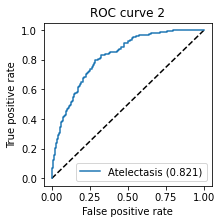

Atelectasis: 0.8210690294811533


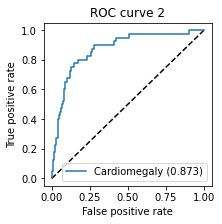

Cardiomegaly: 0.8725239071038251


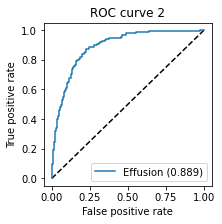

Effusion: 0.8890475772875142


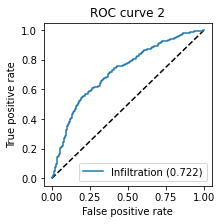

Infiltration: 0.7220461708094217


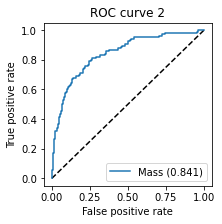

Mass: 0.8406888546980862


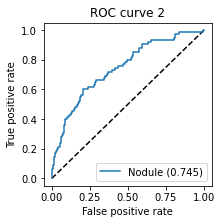

Nodule: 0.744987170515512


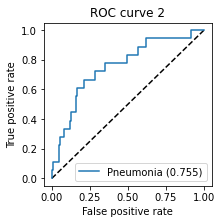

Pneumonia: 0.7550844922984896


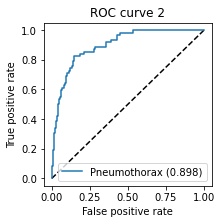

Pneumothorax: 0.8980582524271845


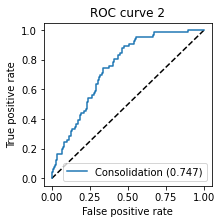

Consolidation: 0.7468601171660977


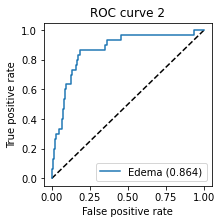

Edema: 0.8643826322930801


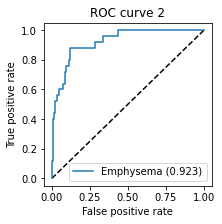

Emphysema: 0.9230561189993238


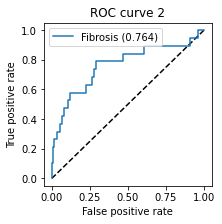

Fibrosis: 0.7642034378876484


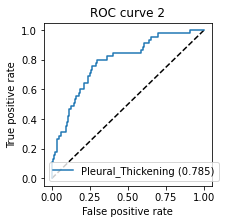

Pleural_Thickening: 0.7849668722869545


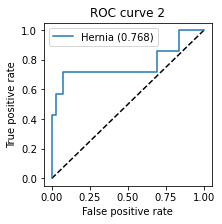

Hernia: 0.7684893596717244
mean auroc: 0.8139617137804296


In [66]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score
print(f"** write log to {test_log_path} **")
aurocs = []
when = '2'
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            gt = y[:,i]
            pred = y_hat[:,i]
            score = roc_auc_score(gt, pred)
            aurocs.append(score)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(3, 3))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                 label=class_names[i] + " (" + str(round(score, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        
            plt.show()
        except ValueError:
            score = 0
            
        print(f"{class_names[i]}: {score}")
        f.write(f"{class_names[i]}: {score}\n")
    mean_auroc = np.mean(aurocs)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")
    

** write log to ./experiments/6\test.log **
Atelectasis: 0.8353368631476579
Cardiomegaly: 0.8801058743169399
Effusion: 0.8879284064761571
Infiltration: 0.7277444485925051
Mass: 0.844771506464761
Nodule: 0.7538698390482854
Pneumonia: 0.8116120831464034
Pneumothorax: 0.9041206210012974
Consolidation: 0.7443524255068067
Edema: 0.8765490728177295
Emphysema: 0.9341717376605815
Fibrosis: 0.7835902888534468
Pleural_Thickening: 0.8143324956210494
Hernia: 0.7697299360626014
mean auroc: 0.826301114194016


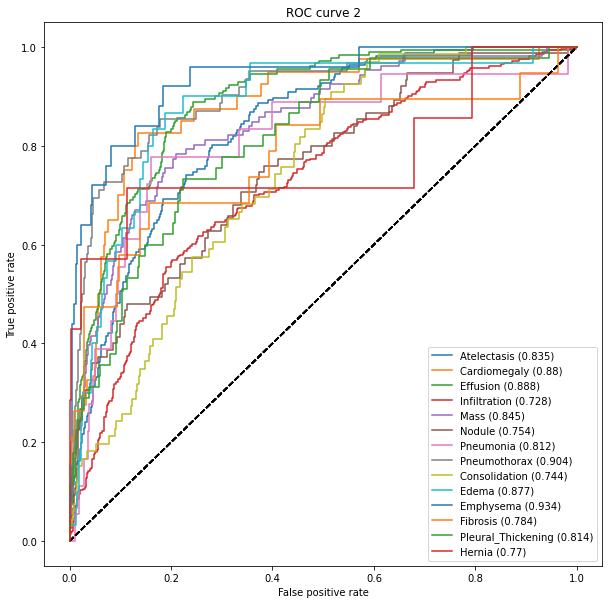

In [39]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score
print(f"** write log to {test_log_path} **")
aurocs = []
when = '2'
with open(test_log_path, "w") as f:
    for i in range(len(class_names)):
        try:
            gt = y[:,i]
            pred = y_hat[:,i]
            score = roc_auc_score(gt, pred)
            aurocs.append(score)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                 label=class_names[i] + " (" + str(round(score, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        
            #plt.show()
        except ValueError:
            score = 0
            
        print(f"{class_names[i]}: {score}")
        f.write(f"{class_names[i]}: {score}\n")
    mean_auroc = np.mean(aurocs)
    f.write("-------------------------\n")
    f.write(f"mean auroc: {mean_auroc}\n")
    print(f"mean auroc: {mean_auroc}")